In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime


from datetime import timedelta, datetime, date
import calendar

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import os
import glob


# This is my preprocessing function, which I run on each grib file

# Load, preprocess, append, and concatenate all the grib files. In this notebook I ran it on half of the data available.

### I will comment the code below for pr_sfc. I repeat the code for each variable separiately. I could loop it for a list of varname =[ 'pr_sfc' , ....] but I preferred keeping it separate.

In [2]:
from glob import glob
variable_names = ['pr_sfc']

def ppf2_filename(ds,filename):
    # rename coordinates
    ds  = ds.rename({ 'lon_0':'lon', 'lat_0':'lat', 'forecast_time0':'time'})
    # getting start time from file name
    ts = filename.split('_')
#     print(ts)
    whereGEFS = ts.index('GEFS')
#     print(whereGEFS)
    dateSstr = ts[whereGEFS+1]
#     print(dateSstr)
    dateS = datetime.strptime(dateSstr, '%d%b%Y')
#     print(dateS)
    
    Mvalue = np.int(float(np.asarray(ts[-1][2:4])))

    ds.coords['S'] = 'S', np.atleast_1d(dateS)
    ds.coords['M'] = 'M', np.atleast_1d(Mvalue)
    
    ds.coords['time']=np.array([  43200000000000,  129600000000000,  216000000000000,
        302400000000000,  388800000000000,  475200000000000,
        561600000000000,  648000000000000,  734400000000000,
        820800000000000,  907200000000000,  993600000000000,
       1080000000000000, 1166400000000000, 1252800000000000,
       1339200000000000, 1425600000000000, 1512000000000000,
       1598400000000000, 1684800000000000, 1771200000000000,
       1857600000000000, 1944000000000000, 2030400000000000,
       2116800000000000, 2203200000000000, 2289600000000000,
       2376000000000000, 2462400000000000, 2548800000000000,
       2635200000000000, 2721600000000000, 2808000000000000,
       2894400000000000, 2980800000000000],
      dtype='timedelta64[ns]')

    # select US
    ds = ds.sel(lat=slice(50,23), lon=slice(230,300))
#     print(ds)
    return ds

def read_netcdfs(files, dim, transform_func=None):
    def process_one_path(path):
        # use a context manager, to ensure the file gets closed after use
#         print(path)
        with xr.open_dataset(path, engine='pynio', chunks={}) as ds:
            # transform_func should do some sort of selection or
            # aggregation
            if transform_func is not None:
                ds = transform_func(ds, path)
            # load all data from the transformed dataset, to ensure we can
            # use it after closing each original file
#             print(ds)
#             ds.load()
            return ds
#     print(files)
    paths = sorted(glob(files))
#     print(paths)
    datasets = [process_one_path(p) for p in paths]
    
    combined = xr.combine_by_coords(datasets)
    combined = combined.chunk({'S':4,'M':-1})
    return combined

var_l=[]
for ivx, ivar in enumerate(variable_names):
    print(ivar)
    if ivar in os.listdir('/Data2/SubX/EMC/GEFS/'):
        c_l = []
        for iy in np.arange(1999, 2017):#2017
            print(iy)
            # here we suppose we only care about the combined mean of each file;
            # you might also use indexing operations like .sel to subset datasets
            combined = read_netcdfs('/Data2/SubX/EMC/GEFS/'+ivar+'/'+np.str(iy)+'/*/*.grb2', dim=['S','M'],
                                    transform_func=ppf2_filename)
            
            c_l.append(combined)
    all_values = xr.concat(c_l, dim='S') 
    var_l.append(all_values)


pr_sfc
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


In [3]:
all_variables = xr.merge(var_l)
all_variables

<xarray.Dataset>
Dimensions:          (M: 10, S: 939, lat: 28, lon: 71, time: 35)
Coordinates:
  * lat              (lat) float32 50.0 49.0 48.0 47.0 ... 26.0 25.0 24.0 23.0
  * M                (M) int64 0 1 2 3 4 5 6 7 8 9
  * time             (time) timedelta64[ns] 0 days 12:00:00 ... 34 days 12:00:00
  * lon              (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * S                (S) datetime64[ns] 1999-01-06 1999-01-13 ... 2016-12-28
Data variables:
    APCP_P1_L1_GLL0  (S, M, time, lat, lon) float32 dask.array<chunksize=(4, 10, 35, 28, 71), meta=np.ndarray>

In [4]:
all_variables = all_variables.rename({'APCP_P1_L1_GLL0':'pr_sfc'})

In [5]:
all_variables

<xarray.Dataset>
Dimensions:  (M: 10, S: 939, lat: 28, lon: 71, time: 35)
Coordinates:
  * lat      (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 27.0 26.0 25.0 24.0 23.0
  * M        (M) int64 0 1 2 3 4 5 6 7 8 9
  * time     (time) timedelta64[ns] 0 days 12:00:00 ... 34 days 12:00:00
  * lon      (lon) float32 230.0 231.0 232.0 233.0 ... 297.0 298.0 299.0 300.0
  * S        (S) datetime64[ns] 1999-01-06 1999-01-13 ... 2016-12-21 2016-12-28
Data variables:
    pr_sfc   (S, M, time, lat, lon) float32 dask.array<chunksize=(4, 10, 35, 28, 71), meta=np.ndarray>

In [6]:
all_variables.load()

<xarray.Dataset>
Dimensions:  (M: 10, S: 939, lat: 28, lon: 71, time: 35)
Coordinates:
  * lat      (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 27.0 26.0 25.0 24.0 23.0
  * M        (M) int64 0 1 2 3 4 5 6 7 8 9
  * time     (time) timedelta64[ns] 0 days 12:00:00 ... 34 days 12:00:00
  * lon      (lon) float32 230.0 231.0 232.0 233.0 ... 297.0 298.0 299.0 300.0
  * S        (S) datetime64[ns] 1999-01-06 1999-01-13 ... 2016-12-21 2016-12-28
Data variables:
    pr_sfc   (S, M, time, lat, lon) float32 1.1 1.2 1.0 ... 0.84 0.65999997 0.39

In [7]:
all_variables.coords['target_time'] = all_variables.S+all_variables.time


# Does climatology depend on lead times?

# calculate climatology for a handful of Target dates (3 day accumulated rain) by pooling 5 S dates and a range of L 1-5, 7-11, 13-17

In [8]:
# Generate target time to check on L dependnece 
target = [ '1900-'+np.str(month).zfill(2)+'-'+np.str(15).zfill(2) for month in np.arange(1,13)]
# transform them in correct dtype
target = [np.datetime64(it) for it in target ]
target = [pd.DatetimeIndex([it]) for it in target ]

In [9]:
MASK_url = 'http://iridl.ldeo.columbia.edu/expert/SOURCES/.Models/.SubX/'
MASK_url1 = '/.hindcast/.pr'
MASK_url2 = '/dup/.SOURCES/.Features/.Political/.World/.Countries/.the_geom/objectid/135/VALUE/rasterize/dods'
url3 = '/Y/(23N)/(50N)/RANGEEDGES/X/(130W)/(60W)/RANGEEDGES'  

i_v_u ='EMC/.GEFS'
#                'GMAO/.GEOS_V2p1',
#                'NRL/.NESM',
#                'RSMAS/.CCSM4',
#                'NCEP/.CFSv2'
              #]

ds_mask = xr.open_dataset(MASK_url+i_v_u+MASK_url1+url3+MASK_url2)
ds_mask['the_geom']=xr.where(ds_mask.the_geom!=0, 1, 0)

ds_mask = ds_mask.rename({'X':'lon', 'Y':'lat'})
ds_mask = ds_mask.isel(objectid=0, drop=True)
ds_mask.coords['lon'] = ds_mask.lon+360.



# re do this with accumulated 3 day rainfall. The accumulation (rolling sum) is done along L

In [10]:
all_variables_3L = all_variables.rolling(time=3).sum()


# The rolling sum assign the right edge value of the interval

In [11]:
all_variables_3L.pr_sfc[0,0,:,10,20]

<xarray.DataArray 'pr_sfc' (time: 35)>
array([           nan,            nan,  1.0000000e-01,  1.0000000e-01,
        1.0000000e-01,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  3.4000001e+00,  6.6999998e+00,  7.2999997e+00,
        1.2400000e+01,  9.0999994e+00,  8.4999990e+00, -9.5367432e-07,
        3.9999990e+00,  3.9999990e+00,  3.9999990e+00, -9.5367432e-07,
       -9.5367432e-07,  9.9999048e-02,  2.9999906e-01,  2.9999906e-01,
        1.9999906e-01, -9.3877316e-07,  1.9999906e-01,  1.9999906e-01,
        1.9999906e-01, -9.3877316e-07,  9.9999063e-02,  9.9999063e-02,
        9.9999063e-02,  9.9999905e-01,  9.9999905e-01], dtype=float32)
Coordinates:
    lat          float32 40.0
    M            int64 0
  * time         (time) timedelta64[ns] 0 days 12:00:00 ... 34 days 12:00:00
    lon          float32 250.0
    S            datetime64[ns] 1999-01-06
    target_time  (time) datetime64[ns] 1999-01-06T12:00:00 ... 1999-02-09T12:00:00

# Here I switch to the left edge of the interval

In [12]:
all_variables_3L.coords['time'] = all_variables_3L.time.values-np.timedelta64(2,'D')

# And drop the first 2 empty values

In [13]:
all_variables_3L = all_variables_3L.isel(time=slice(2,36))
all_variables_3L.pr_sfc[0,0,:,10,20]

<xarray.DataArray 'pr_sfc' (time: 33)>
array([ 1.0000000e-01,  1.0000000e-01,  1.0000000e-01,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  3.4000001e+00,
        6.6999998e+00,  7.2999997e+00,  1.2400000e+01,  9.0999994e+00,
        8.4999990e+00, -9.5367432e-07,  3.9999990e+00,  3.9999990e+00,
        3.9999990e+00, -9.5367432e-07, -9.5367432e-07,  9.9999048e-02,
        2.9999906e-01,  2.9999906e-01,  1.9999906e-01, -9.3877316e-07,
        1.9999906e-01,  1.9999906e-01,  1.9999906e-01, -9.3877316e-07,
        9.9999063e-02,  9.9999063e-02,  9.9999063e-02,  9.9999905e-01,
        9.9999905e-01], dtype=float32)
Coordinates:
    lat          float32 40.0
    M            int64 0
  * time         (time) timedelta64[ns] 0 days 12:00:00 ... 32 days 12:00:00
    lon          float32 250.0
    S            datetime64[ns] 1999-01-06
    target_time  (time) datetime64[ns] 1999-01-08T12:00:00 ... 1999-02-09T12:00:00

# Update the target time, because those have not changed and they are still linked to the right edge of the interval

In [14]:
all_variables_3L.coords['target_time'] = all_variables_3L.S+all_variables_3L.time
all_variables_3L

<xarray.Dataset>
Dimensions:      (M: 10, S: 939, lat: 28, lon: 71, time: 33)
Coordinates:
  * lat          (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 26.0 25.0 24.0 23.0
  * M            (M) int64 0 1 2 3 4 5 6 7 8 9
  * time         (time) timedelta64[ns] 0 days 12:00:00 ... 32 days 12:00:00
  * lon          (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * S            (S) datetime64[ns] 1999-01-06 1999-01-13 ... 2016-12-28
    target_time  (S, time) datetime64[ns] 1999-01-06T12:00:00 ... 2017-01-29T12:00:00
Data variables:
    pr_sfc       (S, M, time, lat, lon) float32 10.5 3.5 ... 1.3400015 1.0199976

In [15]:
all_variables_T3 = all_variables_3L.stack(St=('S','time'))
all_variables_T3 = all_variables_T3.swap_dims({'St':'target_time'})
all_variables_T3 = all_variables_T3.unstack()


In [16]:
all_variables_T3

<xarray.Dataset>
Dimensions:      (M: 10, lat: 28, lon: 71, target_time: 30987)
Coordinates:
  * lat          (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 26.0 25.0 24.0 23.0
  * M            (M) int64 0 1 2 3 4 5 6 7 8 9
  * lon          (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * target_time  (target_time) datetime64[ns] 1999-01-06T12:00:00 ... 2017-01-29T12:00:00
    St           (target_time) object (Timestamp('1999-01-06 00:00:00'), Timedelta('0 days 12:00:00')) ... (Timestamp('2016-12-28 00:00:00'), Timedelta('32 days 12:00:00'))
Data variables:
    pr_sfc       (M, lat, lon, target_time) float32 10.5 38.1 ... 1.0199976

In [17]:
target

[DatetimeIndex(['1900-01-15'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['1900-02-15'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['1900-03-15'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['1900-04-15'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['1900-05-15'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['1900-06-15'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['1900-07-15'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['1900-08-15'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['1900-09-15'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['1900-10-15'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['1900-11-15'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['1900-12-15'], dtype='datetime64[ns]', freq=None)]

In [18]:
# Generate target time to check on L dependnece 
target_all = pd.date_range('1900-01-01', periods=365, freq='D')
target_all = [pd.DatetimeIndex([it]) for it in target_all]
# target_all

In [19]:
# looping through the target dates for climatologies
ds_clim_test_3d_all = []
for iT in target_all:
    # extract values that correspond to the target dates
    temp = all_variables_T3.where((all_variables_T3.target_time.dt.month==iT.month.values[0])&
                              (all_variables_T3.target_time.dt.day==iT.day.values[0]), drop=True)
    
    # bits to extract the S and t of each target_time
    y_ls = [y for (x,y) in temp.St.values]
    y_arr = np.array(y_ls)
    # loop through the 3 types of lead times
    # I have the -1 because of the way the timedelta is centered at 0 day and 12hours for day 1
#     for different_lead1, different_lead2 in zip(np.array([1,7,13])-1, np.array([5,11,17])-1 ):
    for different_lead1, different_lead2 in zip(np.array([2,4,6,8])-1, np.array([10,12,14,16])-1 ):
#         print(y_arr[(y_arr>np.timedelta64(different_lead1,'D'))&(y_arr<np.timedelta64(different_lead2,'D'))])
        temp2 = temp.sel(target_time=
                         (y_arr>np.timedelta64(different_lead1,'D'))&(y_arr<np.timedelta64(different_lead2,'D')))
        temp3 = temp2.stack(Mtt=('M','target_time'))
#         print(temp3.pr_sfc.values.shape)
        temp3 = temp3.quantile(dim=['Mtt'], q=[0.15,0.33,0.5,0.667,0.85])
        temp3 = temp3.expand_dims('Lbeg')
        temp3.coords['Lbeg'] = 'Lbeg', np.atleast_1d(different_lead1+1)
#         print(temp3)
        if different_lead1==1:
            ds_quantile = temp3*1.
        else:
            ds_quantile = xr.merge([ds_quantile,temp3])
    ds_quantile = ds_quantile.expand_dims('target_clim')
    ds_quantile.coords['target_clim'] = 'target_clim', np.atleast_1d(iT)
    ds_clim_test_3d_all.append(ds_quantile)
ds_clim_test_3d_all = xr.combine_by_coords(ds_clim_test_3d_all)    


In [48]:
all_variables_3L

<xarray.Dataset>
Dimensions:      (M: 10, S: 939, lat: 28, lon: 71, time: 33)
Coordinates:
  * lat          (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 26.0 25.0 24.0 23.0
  * M            (M) int64 0 1 2 3 4 5 6 7 8 9
  * time         (time) timedelta64[ns] 0 days 12:00:00 ... 32 days 12:00:00
  * lon          (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * S            (S) datetime64[ns] 1999-01-06 1999-01-13 ... 2016-12-28
    target_time  (S, time) datetime64[ns] 1999-01-06T12:00:00 ... 2017-01-29T12:00:00
Data variables:
    pr_sfc       (S, M, time, lat, lon) float32 10.5 3.5 ... 1.3400015 1.0199976

In [54]:
# looping through the target dates for climatologies
ds_clim_test_3d_all_LongL = []
for iT in target_all:
    # extract values that correspond to the target dates
    temp = all_variables_T3.where((all_variables_T3.target_time.dt.month==iT.month.values[0])&
                              (all_variables_T3.target_time.dt.day==iT.day.values[0]), drop=True)
    
    # bits to extract the S and t of each target_time
    y_ls = [y for (x,y) in temp.St.values]
    y_arr = np.array(y_ls)
    # loop through the 3 types of lead times
    # I have the -1 because of the way the timedelta is centered at 0 day and 12hours for day 1
#     for different_lead1, different_lead2 in zip(np.array([1,7,13])-1, np.array([5,11,17])-1 ):
    for different_lead1, different_lead2 in zip(np.array([4,14])-1, np.array([22,33])-1 ):
#         print(y_arr[(y_arr>np.timedelta64(different_lead1,'D'))&(y_arr<np.timedelta64(different_lead2,'D'))])
        temp2 = temp.sel(target_time=
                         (y_arr>np.timedelta64(different_lead1,'D'))&(y_arr<np.timedelta64(different_lead2,'D')))
        temp3 = temp2.stack(Mtt=('M','target_time'))
        print(temp3.pr_sfc.values.shape)
        temp3 = temp3.quantile(dim=['Mtt'], q=[0.15,0.33,0.5,0.667,0.85])
        temp3 = temp3.expand_dims('Lbeg')
        temp3.coords['Lbeg'] = 'Lbeg', np.atleast_1d(different_lead1+1)
#         print(temp3)
        if different_lead1==3:
            ds_quantile = temp3*1.
        else:
            ds_quantile = xr.merge([ds_quantile,temp3])
    ds_quantile = ds_quantile.expand_dims('target_clim')
    ds_quantile.coords['target_clim'] = 'target_clim', np.atleast_1d(iT)
    ds_clim_test_3d_all_LongL.append(ds_quantile)
ds_clim_test_3d_all_LongL = xr.combine_by_coords(ds_clim_test_3d_all_LongL)    


(28, 71, 470)
(28, 71, 490)
(28, 71, 460)
(28, 71, 480)
(28, 71, 470)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 450)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 460)
(28, 71, 480)
(28, 71, 470)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 450)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 460)
(28, 71, 480)
(28, 71, 470)
(28, 71, 480)
(28, 71, 460)
(28, 71, 480)
(28, 71, 460)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 450)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 460)
(28, 71, 480)
(28, 71, 470)
(28, 71, 480)
(28, 71, 470)
(28, 71, 480)
(28, 71, 470)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 450)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 460)
(28, 71, 480)
(28, 71, 470)
(28, 71, 480)
(28, 71, 470)
(28, 71, 480)
(28, 71, 470)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 450)
(28, 71, 490)
(28, 71, 460)
(28, 7

(28, 71, 460)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 470)
(28, 71, 490)
(28, 71, 460)
(28, 71, 480)
(28, 71, 470)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 470)
(28, 71, 490)
(28, 71, 460)
(28, 71, 480)
(28, 71, 470)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 470)
(28, 71, 490)
(28, 71, 460)
(28, 71, 480)
(28, 71, 470)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 470)
(28, 71, 490)
(28, 71, 460)
(28, 71, 480)
(28, 71, 470)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 470)
(28, 71, 490)
(28, 71, 460)
(28, 71, 480)
(28, 71, 470)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 460)
(28, 71, 490)
(28, 71, 460)
(28, 7

In [20]:
# # looping through the target dates for climatologies
# ds_clim_test_3d_all_wq = []
# for iT in target_all:
#     # extract values that correspond to the target dates
#     temp = all_variables_T3.where((all_variables_T3.target_time.values>=(iT-pd.Timedelta(2,'D')).values)&
#                               (all_variables_T3.target_time.values<=(iT+pd.Timedelta(2,'D')).values), drop=True)
    
#     # bits to extract the S and t of each target_time
#     y_ls = [y for (x,y) in temp.St.values]
#     y_arr = np.array(y_ls)
#     pause
#     # loop through the 3 types of lead times
#     # I have the -1 because of the way the timedelta is centered at 0 day and 12hours for day 1
# #     for different_lead1, different_lead2 in zip(np.array([1,7,13])-1, np.array([5,11,17])-1 ):
#     for different_lead1, different_lead2 in zip(np.array([2,4,6,8])-1, np.array([10,12,14,16])-1 ):
# #         print(y_arr[(y_arr>np.timedelta64(different_lead1,'D'))&(y_arr<np.timedelta64(different_lead2,'D'))])
#         temp2 = temp.sel(target_time=
#                          (y_arr>np.timedelta64(different_lead1,'D'))&(y_arr<np.timedelta64(different_lead2,'D')))
#         temp3 = temp2.stack(Mtt=('M','target_time'))
# #         print(temp3.pr_sfc.values.shape)
#         temp3 = temp3.quantile(dim=['Mtt'], q=[0.15,0.33,0.5,0.667,0.85])
#         temp3 = temp3.expand_dims('Lbeg')
#         temp3.coords['Lbeg'] = 'Lbeg', np.atleast_1d(different_lead1+1)
# #         print(temp3)
#         if different_lead1==1:
#             ds_quantile = temp3*1.
#         else:
#             ds_quantile = xr.merge([ds_quantile,temp3])
#     ds_quantile = ds_quantile.expand_dims('target_clim')
#     ds_quantile.coords['target_clim'] = 'target_clim', np.atleast_1d(iT)
#     ds_clim_test_3d_all_wq.append(ds_quantile)
# ds_clim_test_3d_all_wq = xr.combine_by_coords(ds_clim_test_3d_all_wq)    


In [21]:
# times = pd.date_range('2000-01-01', '2010-12-31', name='time')
# annual_cycle = np.sin(2 * np.pi * (times.dayofyear.values / 366 - 0.28))
# noise = 15 * np.random.rand(annual_cycle.size)
# data = 10 + (15 * annual_cycle) + noise
# da = xr.DataArray(data, coords=[times], dims='time')
# #da.plot()
# #Check variability at one day
# #da.groupby('time.dayofyear').std('time')[0]
# da_clim = da.groupby('time.dayofyear').mean('time')
# _da_clim = xr.concat([da_clim[-15:], da_clim, da_clim[:15]], 'dayofyear')
# da_clim_smooth = _da_clim.rolling(dayofyear=31, center=True).mean().dropna('dayofyear')
# da_clim_smooth.plot()

In [22]:
ds_clim_test_3d_all3 = ds_clim_test_3d_all.rolling(target_clim=3, center=True).mean()
ds_clim_test_3d_all5 = ds_clim_test_3d_all.rolling(target_clim=5, center=True).mean()

# FITTING PROCEDURES

In [23]:
def fffourier(x, *a):
    '''harmonic just with cosine'''
    tau = 366
    ret = a[1] * np.cos(2* np.pi / tau * x)
    for deg in range(2, len(a)):
        ret += a[deg] * np.cos((deg) *2* np.pi / tau * x)
    return ret +a[0]

In [24]:
def fffourierB(x, *a_in):
    '''harmonic with np.exp(sum(sine and cosine))'''
    a_0 = a_in[0]
    len_a = len(a_in)-1
#     print(len_a, int(len_a/2))
    if len_a==3:
        a = a_in[1]
        b = a_in[2]
    else:
        a = a_in[1:int(len_a/2+1)]
        b = a_in[int(len_a/2+1):]
#     print(a,b)
    tau = 365.25
    nu = 2*np.pi/tau
    ret = a_0
    for deg in range(0,int(len_a/2)):
#         print(deg)
#         print(a[deg] , b[deg] )
        ret += a[deg] * np.sin((deg+1) * nu * x) + b[deg] * np.cos((deg+1) * nu * x)
#     if any(np.abs(a))>=19:
#         ret*=10000
#     if any(np.abs(b))>=19:
#         ret*=10000
    return np.exp(ret)

In [25]:
# def fffourierC(x, *a_in):
#     '''harmonic with sum(sine and cosine)'''
#     a_0 = a_in[0]
#     len_a = len(a_in)-1
# #     print(len_a, int(len_a/2))
#     if len_a==3:
#         a = a_in[1]
#         b = a_in[2]
#     else:
#         a = a_in[1:int(len_a/2+1)]
#         b = a_in[int(len_a/2+1):]
# #     print(a,b)
#     tau = 365.25
#     nu = 2*np.pi/tau
#     ret = a_0
#     for deg in range(0,int(len_a/2)):
# #         print(deg)
# #         print(a[deg] , b[deg] )
#         ret += a[deg] * np.sin((deg+1) * nu * x) + b[deg] * np.cos((deg+1) * nu * x)
#     return ret

In [26]:
# def fffourierL(x, *a_in):
#     '''harmonic with sum(sine and cosine) to the log of intensity'''

#     a_0 = a_in[0]
#     len_a = len(a_in)-1
# #     print(len_a, int(len_a/2))
#     if len_a==3:
#         a = a_in[1]
#         b = a_in[2]
#     else:
#         a = a_in[1:int(len_a/2+1)]
#         b = a_in[int(len_a/2+1):]
# #     print(a,b)
#     tau = 365.25
#     nu = 2*np.pi/tau
#     ret = a_0
#     for deg in range(0,int(len_a/2)):
# #         print(deg)
# #         print(a[deg] , b[deg] )
#         ret +=a[deg]*np.sin((deg+1) * nu * x) + b[deg] * np.cos((deg+1) * nu * x)
#     return ret

In [27]:
# from scipy.optimize import curve_fit
# x = ds_clim_test_3d_all.target_clim.dt.dayofyear.values
# y = ds_clim_test_3d_all.pr_sfc[:,3,-1,2,30].values

# # x = np.concatenate((x[290:]-365,x,x[:100]+365))
# # y =  np.concatenate((y[290:],y,y[:100]))
# popt, pcov = curve_fit(fffourierB, x,y, [1]*9)
# # popt, pcov = curve_fit(fffourier, x,y, [0] * 9)
# print(popt)

In [28]:
def apply_fffourier(dsin):
    x = dsin.target_clim.dt.dayofyear.values
#     print(dsin)
#     print(x.shape)
    popt = dsin.H.values
    out = fffourierB(x, *popt)
#     print(out)
#     pause
#     print(popt)
    # we need to return a dataarray or else xarray's groupby won't be happy
    return xr.DataArray(out)


In [29]:
# def apply_fffourierL(dsin):
#     x = dsin.target_clim.dt.dayofyear.values
# #     print(dsin)
# #     print(x.shape)
#     popt = dsin.H.values
#     out = fffourierL(x, *popt)
# #     print(out)
# #     pause
# #     print(popt)
#     # we need to return a dataarray or else xarray's groupby won't be happy
#     return xr.DataArray(out)


In [30]:
# def apply_fffourierC(dsin):
#     x = dsin.target_clim.dt.dayofyear.values
# #     print(dsin)
# #     print(x.shape)
#     popt = dsin.H.values
#     out = fffourierC(x, *popt)
# #     print(out)
# #     pause
# #     print(popt)
#     # we need to return a dataarray or else xarray's groupby won't be happy
#     return xr.DataArray(out)


In [31]:
# def apply_fit_curveb(dsin, loss_f):
#     x = dsin.target_clim.dt.dayofyear.values
# #     print(x.shape)
#     y = dsin.values
# #     print(y.shape)
# #     pause
# #     print(y)
    
#     if np.sum(np.isnan(y))==0:
#         y[y<0]=0

#         try:
#             num_armonics = 9
#             popt, pcov = curve_fit(fffourierB, x,y, [10.0] * num_armonics, bounds=[-20,20], maxfev=3000)
#         except:
#             try:
#                 num_armonics = 7
#                 print(7)
#                 print(dsin.coords)
#                 popt, pcov = curve_fit(fffourierB, x,y, [1.0] * num_armonics,bounds=[-20,20])
#             except:
#                 try:
#                     num_armonics = 5
#                     print(5)
#                     print(dsin.coords)
#                     popt, pcov = curve_fit(fffourierB, x,y[:,0], [1.0] * num_armonics, bounds=[-20,20])
#                 except:
#                     try:
#                         num_armonics = 3
#                         print(3)
#                         print(dsin.coords)
#                         popt, pcov = curve_fit(fffourierB, x,y[:,0], [1.0] * num_armonics, bounds=[-20,20])
#                     except:
#                         print('failed', dsin)
#                         popt = np.nan*np.ones(3)
#     else:
#         popt=np.nan*np.ones(9)
#         num_armonics = 9
# #     popt, pcov = curve_fit(fffourierB, x,y[:,0], [10.0] * 9)
# #     print(popt)
#     # we need to return a dataarray or else xarray's groupby won't be happy
#     return xr.DataArray(popt, coords=[np.arange(0,num_armonics)], dims='harmonic')
# #     return xr.DataArray(popt, coords=[np.arange(0,9)], dims='harmonic')


In [32]:
from scipy.optimize import curve_fit


In [35]:
def apply_fit_curve_cauchy(dsin):
#     print(dsin.coords)
#     print(loss_f[:])
#     pause
    x = dsin.target_clim.dt.dayofyear.values
#     print(x.shape)
    y = dsin.pr_sfc.values[:,0]
    if np.sum(np.isnan(y))==0:
        y[y<0]=0

#         try:
#             num_armonics = 9
#             popt, pcov = curve_fit(fffourierB, x,y[:,0], [0.0] * num_armonics, bounds=[-15,15])
#         except:
#         try:
        num_armonics = 7
        popt, pcov = curve_fit(fffourierB, x,y, [0.0] * num_armonics, bounds=[-20,20], 
                               max_nfev=3000, loss='cauchy')
#         except:
#             try:
#                 num_armonics = 5
#                 print(5)
#                 print(dsin.coords)
#                 popt, pcov = curve_fit(fffourierB, x,y[:,0], [0.0] * num_armonics, bounds=[-20,20],
#                                         max_nfev=3000, loss='cauchy')
#             except:
#                 try:
#                     num_armonics = 3
#                     print(3)
#                     print(dsin.coords)
#                     popt, pcov = curve_fit(fffourierB, x,y[:,0], [0.0] * num_armonics, bounds=[-20,20], 
#                                             max_nfev=3000, loss='cauchy')
#                 except:
#                     print('failed', dsin)
#                     popt = np.nan*np.ones(3)
    else:
        popt=np.nan*np.ones(7)
        num_armonics = 7

    # we need to return a dataarray or else xarray's groupby won't be happy
    return xr.DataArray(popt, coords=[np.arange(0,num_armonics)], dims='harmonic')


In [34]:
def apply_fit_curve_soft(dsin):
#     print(loss_f[:])
#     pause
    x = dsin.target_clim.dt.dayofyear.values
#     print(x.shape)
    y = dsin.pr_sfc.values[:,0]
    
    if np.sum(np.isnan(y))==0:
        y[y<0]=0

#         try:
#             num_armonics = 9
#             popt, pcov = curve_fit(fffourierB, x,y[:,0], [0.0] * num_armonics, bounds=[-15,15])
#         except:
        try:
            num_armonics = 7
            popt, pcov = curve_fit(fffourierB, x,y, [0.0] * num_armonics, bounds=[-20,20], max_nfev=3000)
        except:
            try:
                num_armonics = 5
                print(5)
                print(dsin.coords)
                popt, pcov = curve_fit(fffourierB, x,y[:,0], [0.0] * num_armonics, bounds=[-20,20],
                                        max_nfev=3000)
            except:
                try:
                    num_armonics = 3
                    print(3)
                    print(dsin.coords)
                    popt, pcov = curve_fit(fffourierB, x,y[:,0], [0.0] * num_armonics, bounds=[-20,20], 
                                            max_nfev=3000)
                except:
                    print('failed', dsin)
                    popt = np.nan*np.ones(3)
    else:
        popt=np.nan*np.ones(7)
        num_armonics = 7

    # we need to return a dataarray or else xarray's groupby won't be happy
    return xr.DataArray(popt, coords=[np.arange(0,num_armonics)], dims='harmonic')


# Apply curve fit


In [38]:
ds_clim_test_3d_all

<xarray.Dataset>
Dimensions:      (Lbeg: 4, lat: 28, lon: 71, quantile: 5, target_clim: 365)
Coordinates:
  * lat          (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 26.0 25.0 24.0 23.0
  * lon          (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * quantile     (quantile) float64 0.15 0.33 0.5 0.667 0.85
  * Lbeg         (Lbeg) int64 2 4 6 8
  * target_clim  (target_clim) datetime64[ns] 1900-01-01 ... 1900-12-31
Data variables:
    pr_sfc       (target_clim, Lbeg, quantile, lat, lon) float64 2.3 ... 12.7

In [67]:
# stacked = ds_clim_test_3d_all.where(ds_mask.the_geom>0).isel(quantile=slice(-1, None)).stack(
stacked = ds_clim_test_3d_all.where(ds_mask.the_geom>0).sel(quantile=0.85).stack(
    allpoints=['Lbeg','lat','lon'])  
trend = stacked.groupby('allpoints').apply(apply_fit_curve_cauchy)


In [55]:
stacked = ds_clim_test_3d_all_LongL.where(ds_mask.the_geom>0).sel(quantile=0.85).stack(
    allpoints=['Lbeg','lat','lon'])  
trend_LongL = stacked.groupby('allpoints').apply(apply_fit_curve_cauchy)
trend_unstacked_LongL = trend_LongL.unstack('allpoints')
trend_unstacked_LongL = trend_unstacked_LongL.rename({'allpoints_level_0':'Lbeg',
                                          'allpoints_level_1':'lat',
                                         'allpoints_level_2':'lon'})
trend_unstacked_LongL = trend_unstacked_LongL.to_dataset(name='H')
trend_unstacked_LongL.coords['target_clim'] = 'target_clim', stacked.target_clim.values


In [38]:
ds1 = ds_clim_test_3d_all.rolling(lat = 3, center=True).mean()
ds2 = ds_clim_test_3d_all.rolling(lon = 3, center=True).mean()
dsroll = (ds1+ds2)/2

In [39]:
stacked = dsroll.where(ds_mask.the_geom>0).sel(quantile=0.85).stack(
    allpoints=['Lbeg','lat','lon'])  
trendroll = stacked.groupby('allpoints').apply(apply_fit_curve_cauchy)


In [ ]:
trend1 = stacked.groupby('allpoints').apply(apply_fit_curve_soft)


In [68]:
trend_unstacked = trend.unstack('allpoints')
trend_unstacked = trend_unstacked.rename({'allpoints_level_0':'Lbeg',
                                          'allpoints_level_1':'lat',
                                         'allpoints_level_2':'lon'})
trend_unstacked = trend_unstacked.to_dataset(name='H')
trend_unstacked.coords['target_clim'] = 'target_clim', stacked.target_clim.values


In [41]:
trend_unstackedroll = trendroll.unstack('allpoints')
trend_unstackedroll = trend_unstackedroll.rename({'allpoints_level_0':'Lbeg',
                                          'allpoints_level_1':'lat',
                                         'allpoints_level_2':'lon'})
trend_unstackedroll = trend_unstackedroll.to_dataset(name='H')
trend_unstackedroll.coords['target_clim'] = 'target_clim', stacked.target_clim.values


In [57]:
trend_unstacked2 = trend1.unstack('allpoints')
trend_unstacked2 = trend_unstacked2.rename({'allpoints_level_0':'Lbeg',
                                          'allpoints_level_1':'lat',
                                         'allpoints_level_2':'lon'})
trend_unstacked2 = trend_unstacked2.to_dataset(name='H')
trend_unstacked2.coords['target_clim'] = 'target_clim', stacked.target_clim.values

NameError: name 'trend1' is not defined

<Figure size 432x288 with 0 Axes>

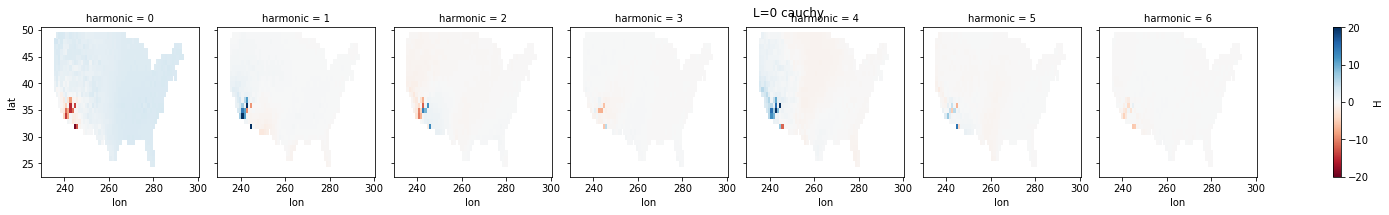

<Figure size 432x288 with 0 Axes>

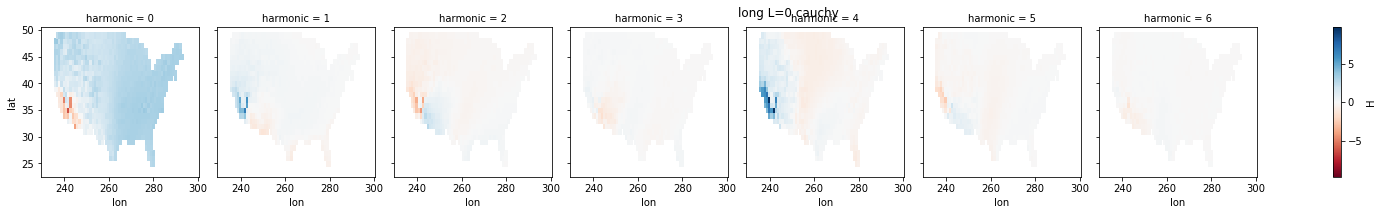

<Figure size 432x288 with 0 Axes>

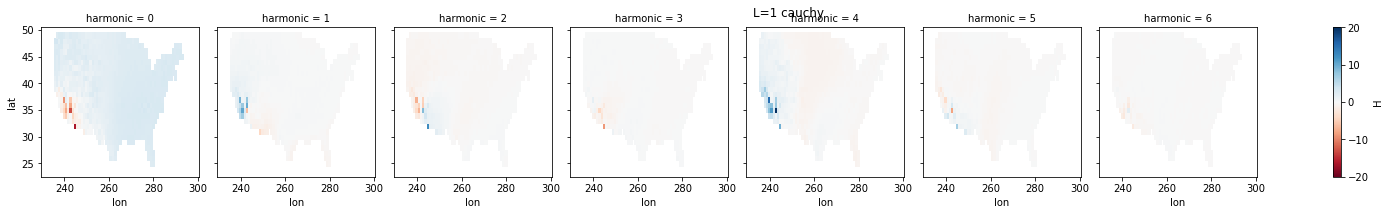

<Figure size 432x288 with 0 Axes>

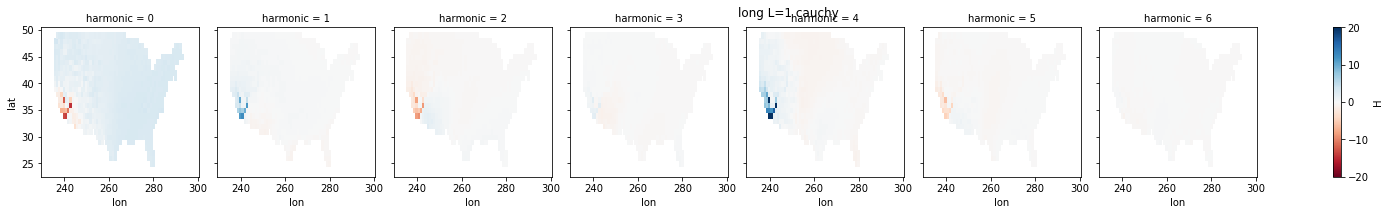

<Figure size 432x288 with 0 Axes>

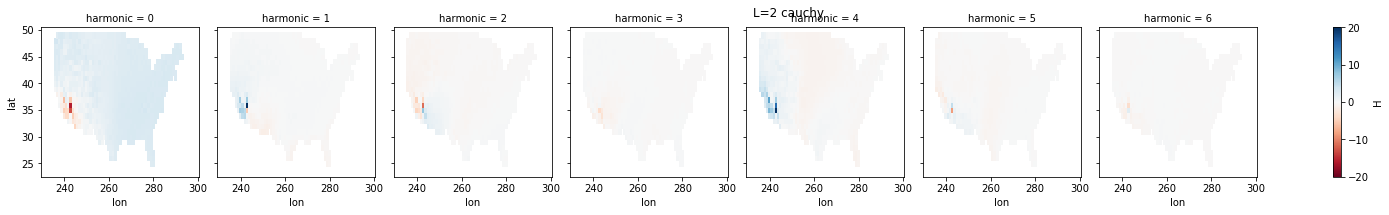

<Figure size 432x288 with 0 Axes>

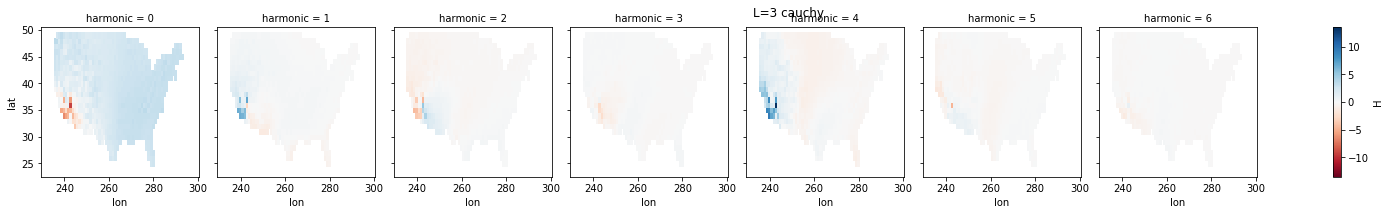

In [58]:
for Li in np.arange(0,4):
    plt.figure()
    trend_unstacked.H[:,Li].where(ds_mask.the_geom>0).plot(col='harmonic', cmap='RdBu')
    plt.suptitle('L='+np.str(Li)+' cauchy')
#     plt.figure()
#     trend_unstacked2.H[:,Li].where(ds_mask.the_geom>0).plot(col='harmonic', cmap='RdBu')
#     plt.suptitle('L='+np.str(Li)+' soft')
    if Li<2:
        plt.figure()    
        trend_unstacked_LongL.H[:,Li].where(ds_mask.the_geom>0).plot(col='harmonic', cmap='RdBu')
        plt.suptitle('long L='+np.str(Li)+' cauchy')
    
    

In [ ]:
for Li in np.arange(0,4):
    plt.figure()
    trend_unstacked.H[:,Li].where(ds_mask.the_geom>0).plot(col='harmonic', cmap='RdBu', vmin=-5,vmax=5)
    plt.suptitle(Li)
    plt.figure()
    trend_unstacked2.H[:,Li].where(ds_mask.the_geom>0).plot(col='harmonic', cmap='RdBu', vmin=-5,vmax=5)
    plt.suptitle(Li)
    
    

In [ ]:
trend_unstacked.to_netcdf('harmonics_from_quantiles_cauchy.nc')


In [59]:
trend_unstacked_LongL.to_netcdf('harmonics_from_quantiles_cauchy_LongL.nc')
# trend_unstacked2.to_netcdf('harmonics_from_quantiles_soft.nc')

In [42]:
trend_unstacked.to_netcdf('harmonics_from_quantiles_cauchyB.nc')
trend_unstackedroll.to_netcdf('harmonics_from_quantiles_cauchyrollB.nc')


# Rebuild data based on coefficients

In [69]:
stack1 = trend_unstacked.stack(allpoints=['Lbeg','lat','lon'])  
smooth_clim = stack1.groupby('allpoints').apply(apply_fffourier)
smooth_clim = smooth_clim.unstack('allpoints')
smooth_clim = smooth_clim.rename({'dim_0':'target_clim'})
smooth_clim.coords['target_clim'] = 'target_clim',stacked.target_clim.values
smooth_clim_cauchy = smooth_clim.to_dataset(name='pr_sfc')

In [60]:
stack1 = trend_unstacked_LongL.stack(allpoints=['Lbeg','lat','lon'])  
smooth_clim = stack1.groupby('allpoints').apply(apply_fffourier)
smooth_clim = smooth_clim.unstack('allpoints')
smooth_clim = smooth_clim.rename({'dim_0':'target_clim'})
smooth_clim.coords['target_clim'] = 'target_clim',stacked.target_clim.values
smooth_clim_cauchy_LongL = smooth_clim.to_dataset(name='pr_sfc')

In [ ]:
stack1 = trend_unstacked2.stack(allpoints=['Lbeg','lat','lon'])  
smooth_clim = stack1.groupby('allpoints').apply(apply_fffourier)
smooth_clim = smooth_clim.unstack('allpoints')
smooth_clim = smooth_clim.rename({'dim_0':'target_clim'})
smooth_clim.coords['target_clim'] = 'target_clim',stacked.target_clim.values
smooth_clim_soft = smooth_clim.to_dataset(name='pr_sfc')

In [ ]:
ds_clim_test_3d_all = xr.open_dataset('ds_clim_test_3d.nc')

# Plot data and reconstructed climatologies

In [ ]:
ds_clim_test_3d_all

In [82]:
import cmocean
cmap = cmocean.cm.deep


In [95]:
ds_clim_test_3d_all_LongL.sel(lat=34 , lon=255, quantile=0.85)

<xarray.Dataset>
Dimensions:      (Lbeg: 2, target_clim: 365)
Coordinates:
  * Lbeg         (Lbeg) int64 4 14
    lat          float32 34.0
    quantile     float64 0.85
    lon          float32 255.0
  * target_clim  (target_clim) datetime64[ns] 1900-01-01 ... 1900-12-31
Data variables:
    pr_sfc       (target_clim, Lbeg) float64 2.565 3.765 3.515 ... 3.5 2.6 3.7

In [99]:
ds_clim_test_3d_all_LongL.sel(lat=34 , lon=255, quantile=0.85).isel(Lbeg=0)

<xarray.Dataset>
Dimensions:      (target_clim: 365)
Coordinates:
    Lbeg         int64 4
    lat          float32 34.0
    quantile     float64 0.85
    lon          float32 255.0
  * target_clim  (target_clim) datetime64[ns] 1900-01-01 ... 1900-12-31
Data variables:
    pr_sfc       (target_clim) float64 2.565 3.515 2.7 2.6 ... 2.449 2.5 2.6

In [ ]:
dsin = ds_clim_test_3d_all_LongL.sel(lat=34 , lon=255, quantile=0.85).isel(Lbeg=0)
x = dsin.target_clim.dt.dayofyear.values
#     print(x.shape)
y = dsin.pr_sfc.values

num_armonics = 7
popt1, pcov = curve_fit(fffourierB, x,y, [0.0] * num_armonics, bounds=[-20,20], 
                       max_nfev=3000, loss='cauchy')
print(popt1)

dsin = ds_clim_test_3d_all_LongL.sel(lat=34 , lon=255, quantile=0.85).isel(Lbeg=1)
x = dsin.target_clim.dt.dayofyear.values
#     print(x.shape)
y = dsin.pr_sfc.values

num_armonics = 7
popt2, pcov = curve_fit(fffourierB, x,y, [0.0] * num_armonics, bounds=[-20,20], 
                       max_nfev=3000, loss='cauchy')
num_armonics = 7
popt4, pcov = curve_fit(fffourierB, x,y,  [0.0] * 13, bounds=[-20,20], 
                       max_nfev=3000, loss='cauchy')
print(popt2)

dsin = ds_clim_test_3d_all_LongL.sel(lat=34 , lon=255, quantile=0.85)
x = dsin.target_clim.dt.dayofyear.values
#     print(x.shape)
y1 = dsin.pr_sfc.isel(Lbeg=0).values
y2 = dsin.pr_sfc.isel(Lbeg=1).values

xt = np.concatenate((x,x+366))
yt = np.concatenate((y1,y2))
num_armonics = 7
popt3, pcov = curve_fit(fffourierB, xt,yt, [0.0] * num_armonics, bounds=[-20,20], 
                       max_nfev=3000, loss='cauchy')
print(popt3)


out1 = fffourierB(x, *popt1)
out2 = fffourierB(x, *popt2)
out3 = fffourierB(x, *popt3)
out4 = fffourierB(x, *popt4)

plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x, out1, 'r')
plt.plot(x, out2, 'b')
plt.plot(x, out3, 'm')
plt.plot(x, out4, 'c')


/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


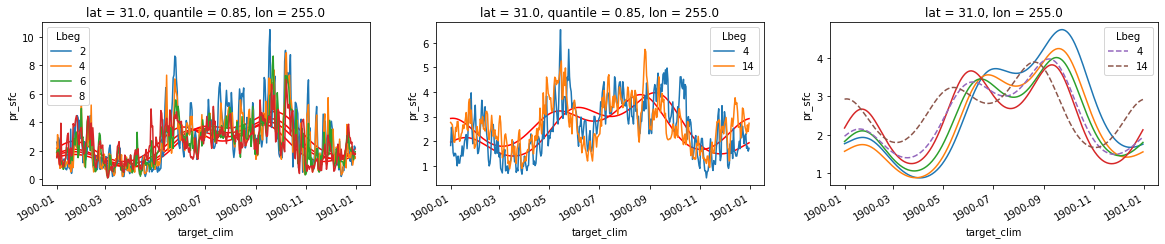

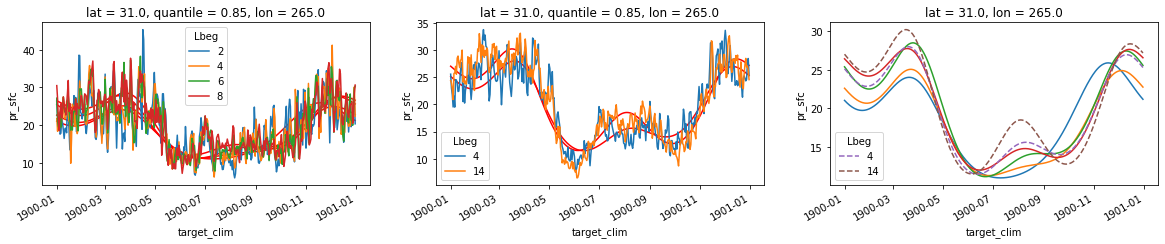

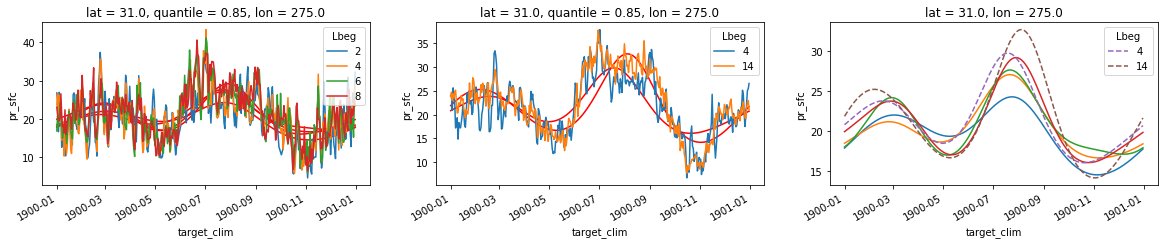

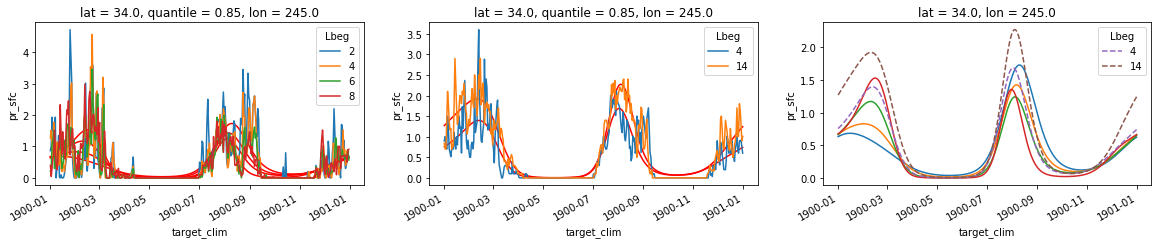

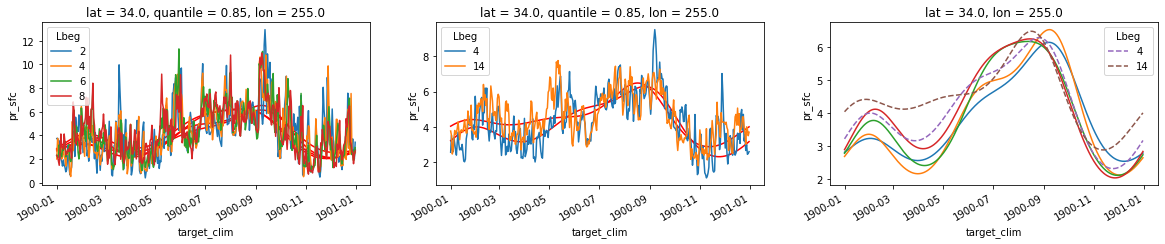

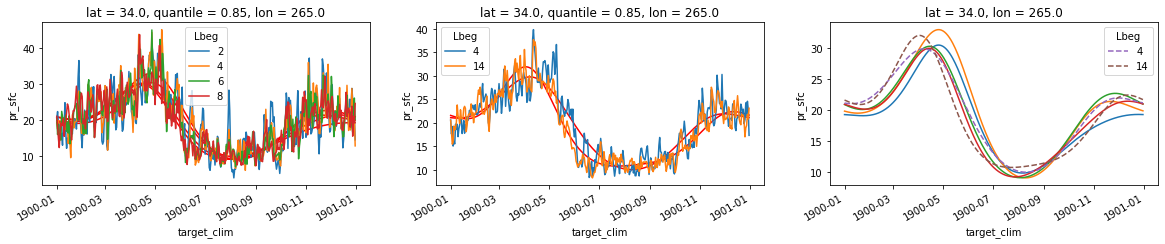

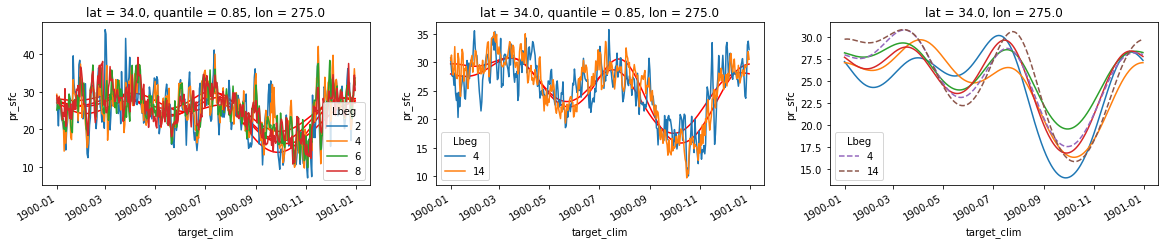

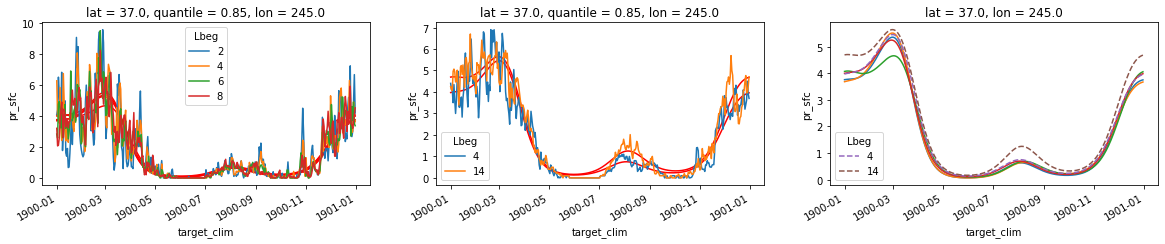

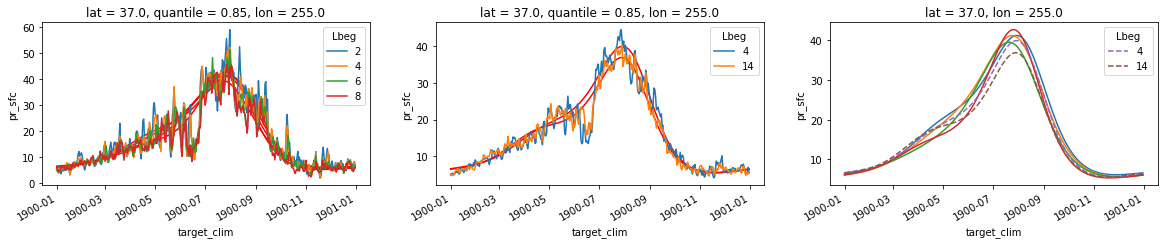

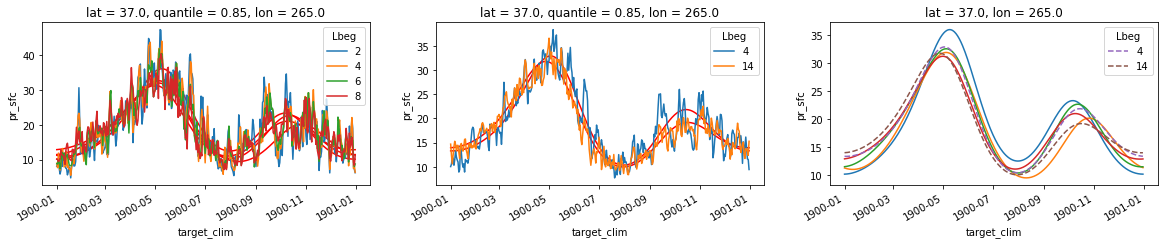

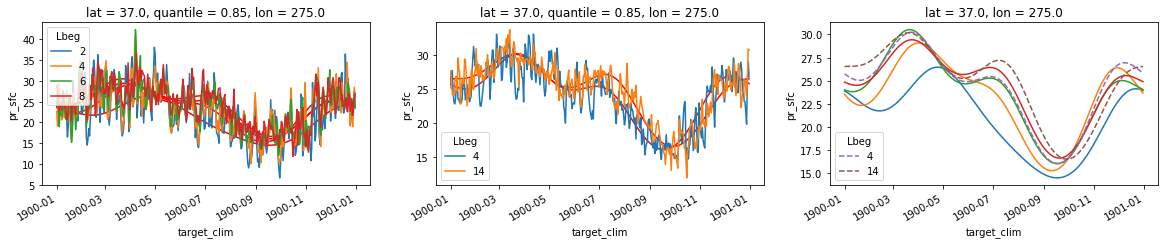

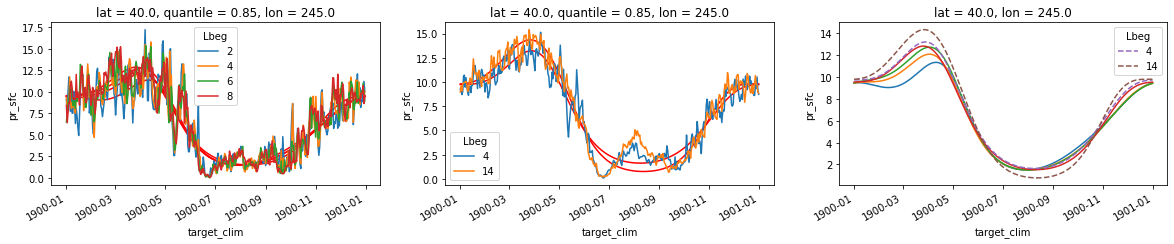

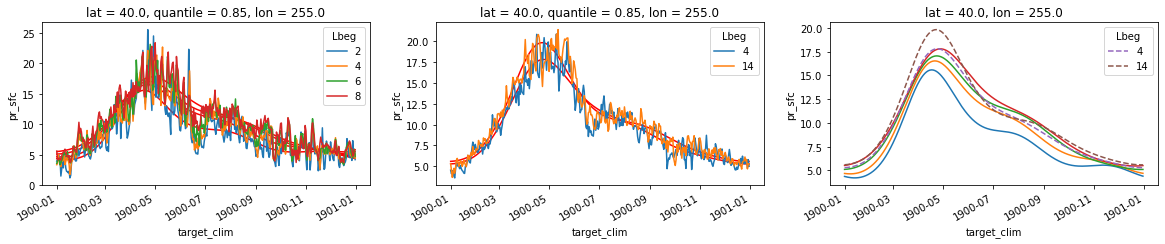

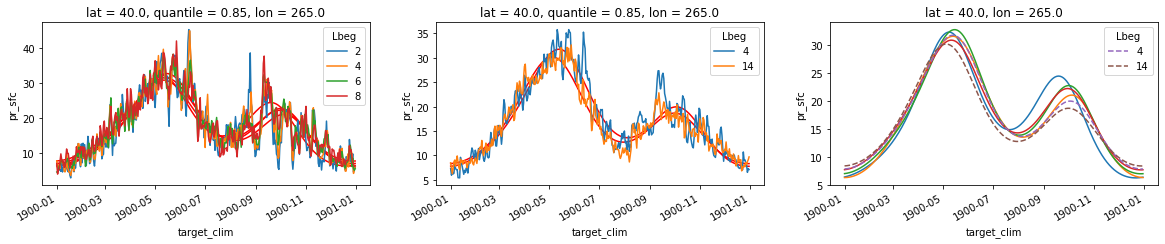

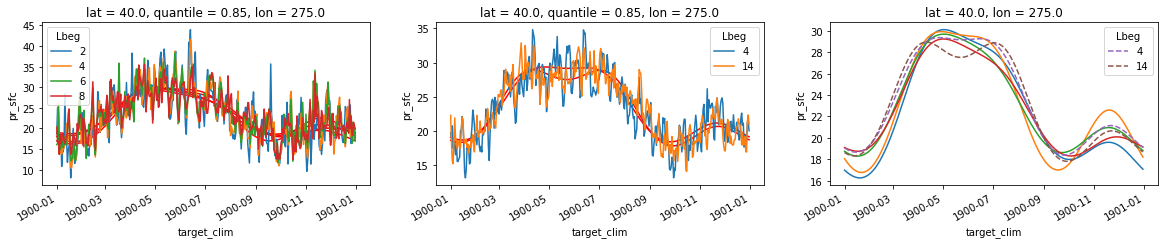

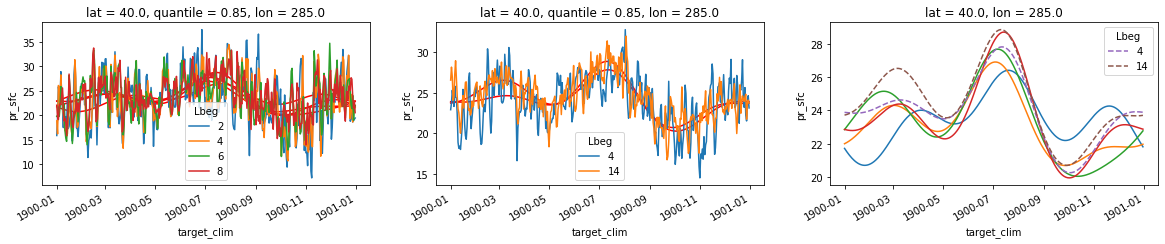

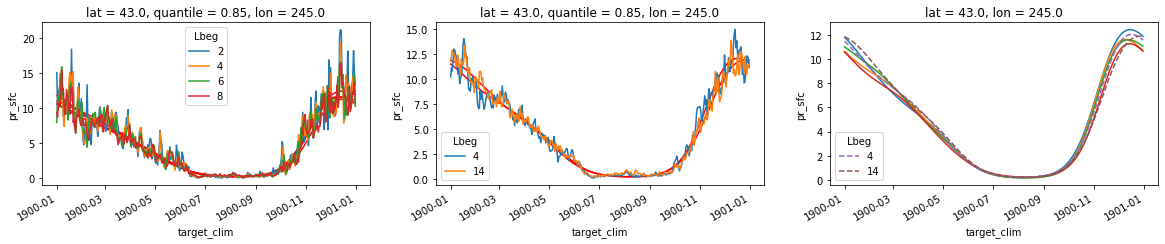

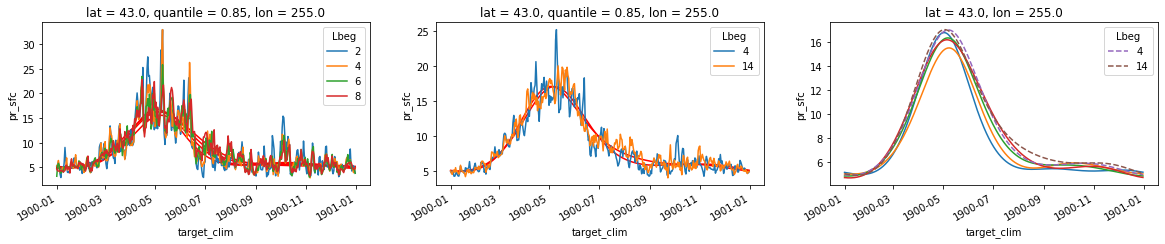

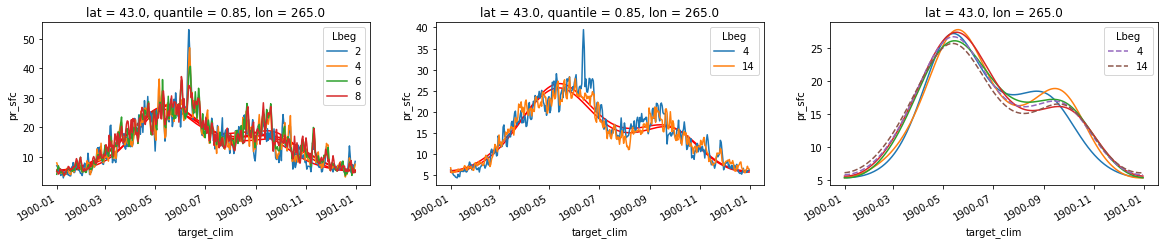

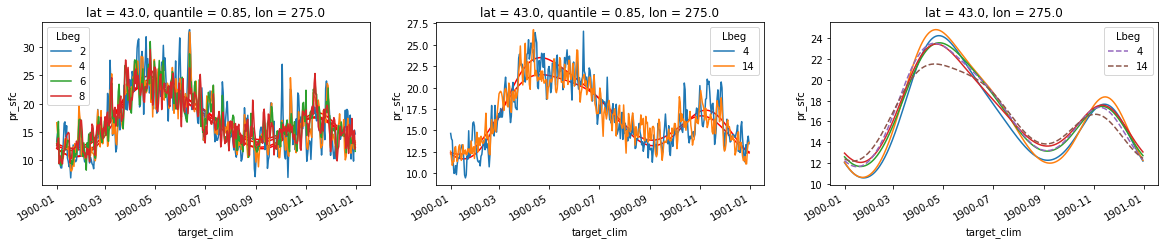

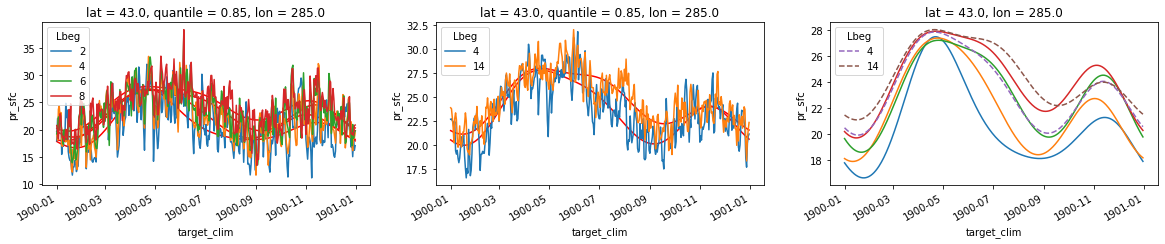

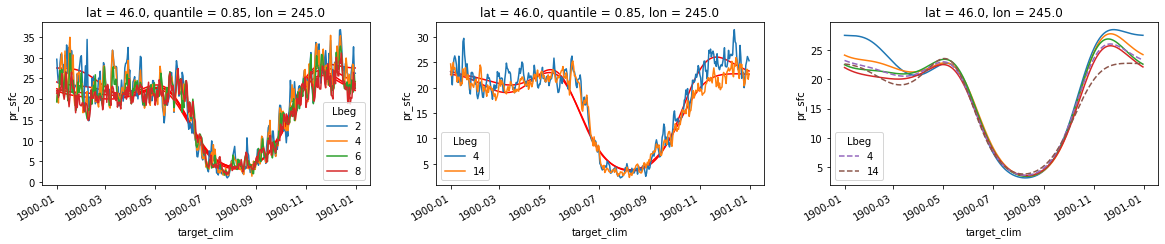

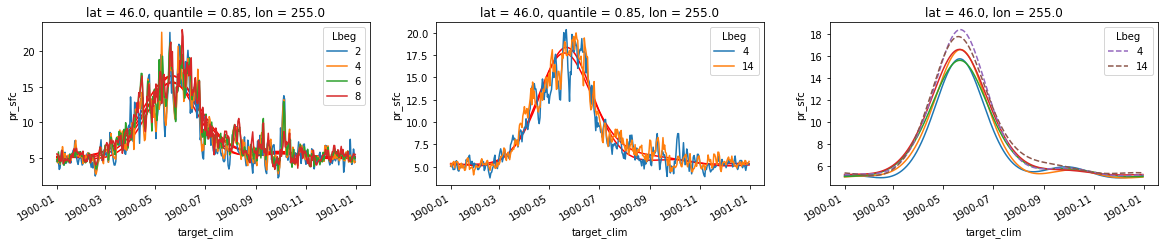

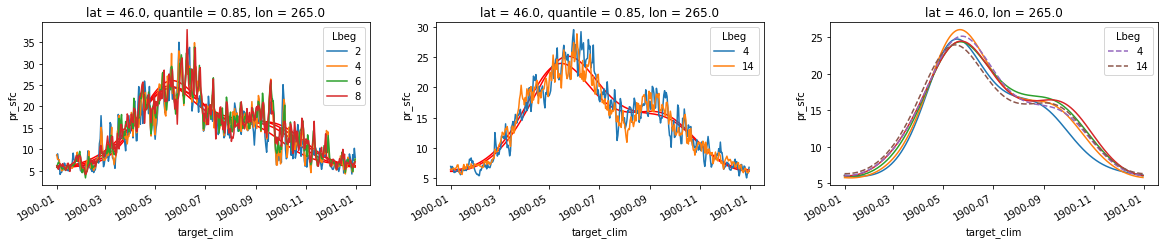

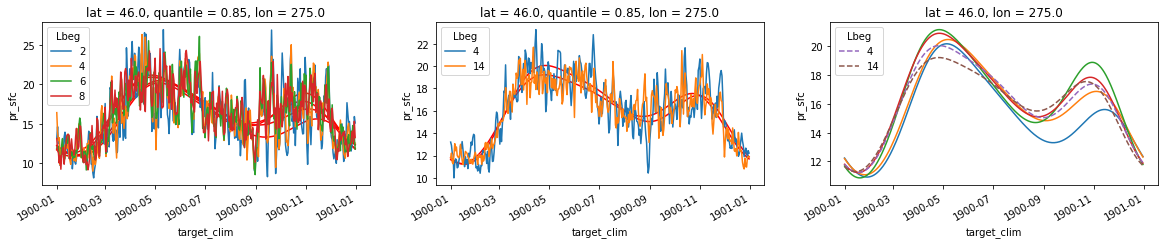

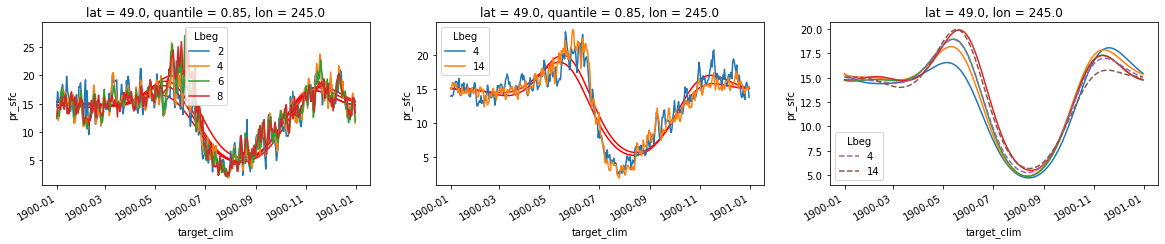

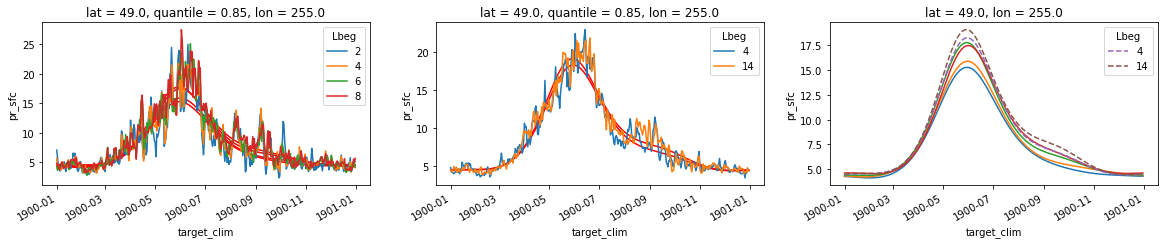

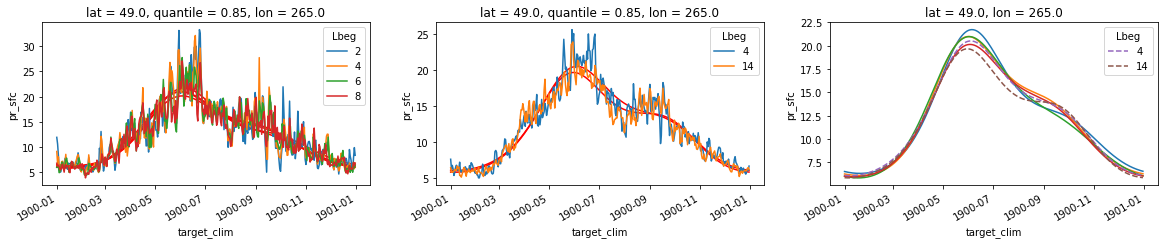

In [70]:
for ilat in np.arange(25,51,3):
    for ilon in np.arange(235,301,10):
        if np.sum(np.isnan(ds_clim_test_3d_all.where(ds_mask.the_geom>0).pr_sfc[:,:,-1,:,:].sel(lat=ilat, lon=ilon).values))==0:
            plt.figure(figsize=(20,3))
            ax = plt.subplot(131)
#             smooth_clim_soft.pr_sfc[:,:,:,:].sel(lat=ilat, lon=ilon).plot.line('b',x='target_clim')
            smooth_clim_cauchy.pr_sfc[:,:,:,:].sel(lat=ilat, lon=ilon).plot.line('r',ax=ax, x='target_clim')
            ds_clim_test_3d_all.where(ds_mask.the_geom>0).pr_sfc[:,:,-1,:,:].sel(lat=ilat, lon=ilon).plot.line(ax=ax, x='target_clim')
            ax = plt.subplot(132)
#             smooth_clim_soft.pr_sfc[:,:,:,:].sel(lat=ilat, lon=ilon).plot.line('b',x='target_clim')
            smooth_clim_cauchy_LongL.pr_sfc[:,:,:,:].sel(lat=ilat, lon=ilon).plot.line('r',ax=ax, x='target_clim')
            ds_clim_test_3d_all_LongL.where(ds_mask.the_geom>0).pr_sfc[:,:,-1,:,:].sel(lat=ilat, lon=ilon).plot.line(ax=ax, x='target_clim')
        
            ax = plt.subplot(133)
            smooth_clim_cauchy.pr_sfc[:,:,:,:].sel(lat=ilat, lon=ilon).plot.line(ax=ax, x='target_clim')
            smooth_clim_cauchy_LongL.pr_sfc[:,:,:,:].sel(lat=ilat, lon=ilon).plot.line('--',ax=ax, x='target_clim')


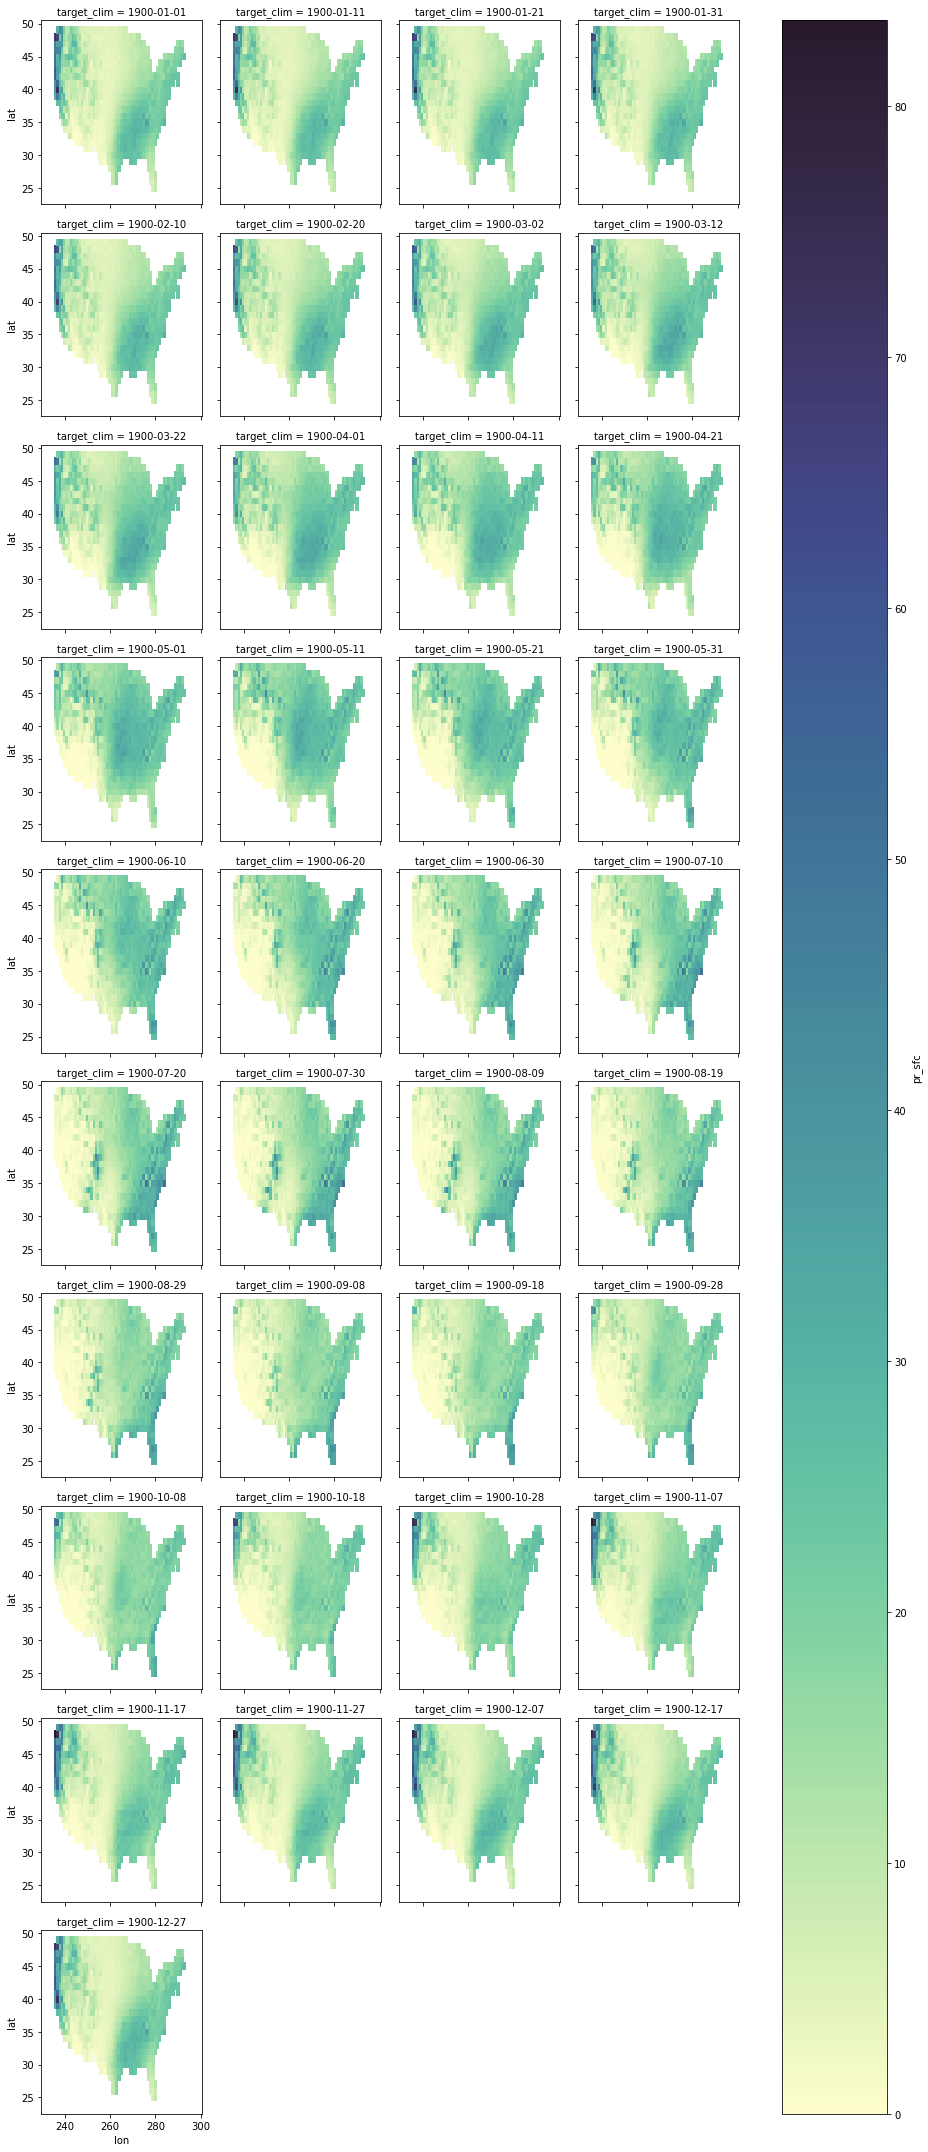

In [83]:
smooth_clim_cauchy.pr_sfc[::10,3].plot(col='target_clim',col_wrap=4, cmap=cmap)

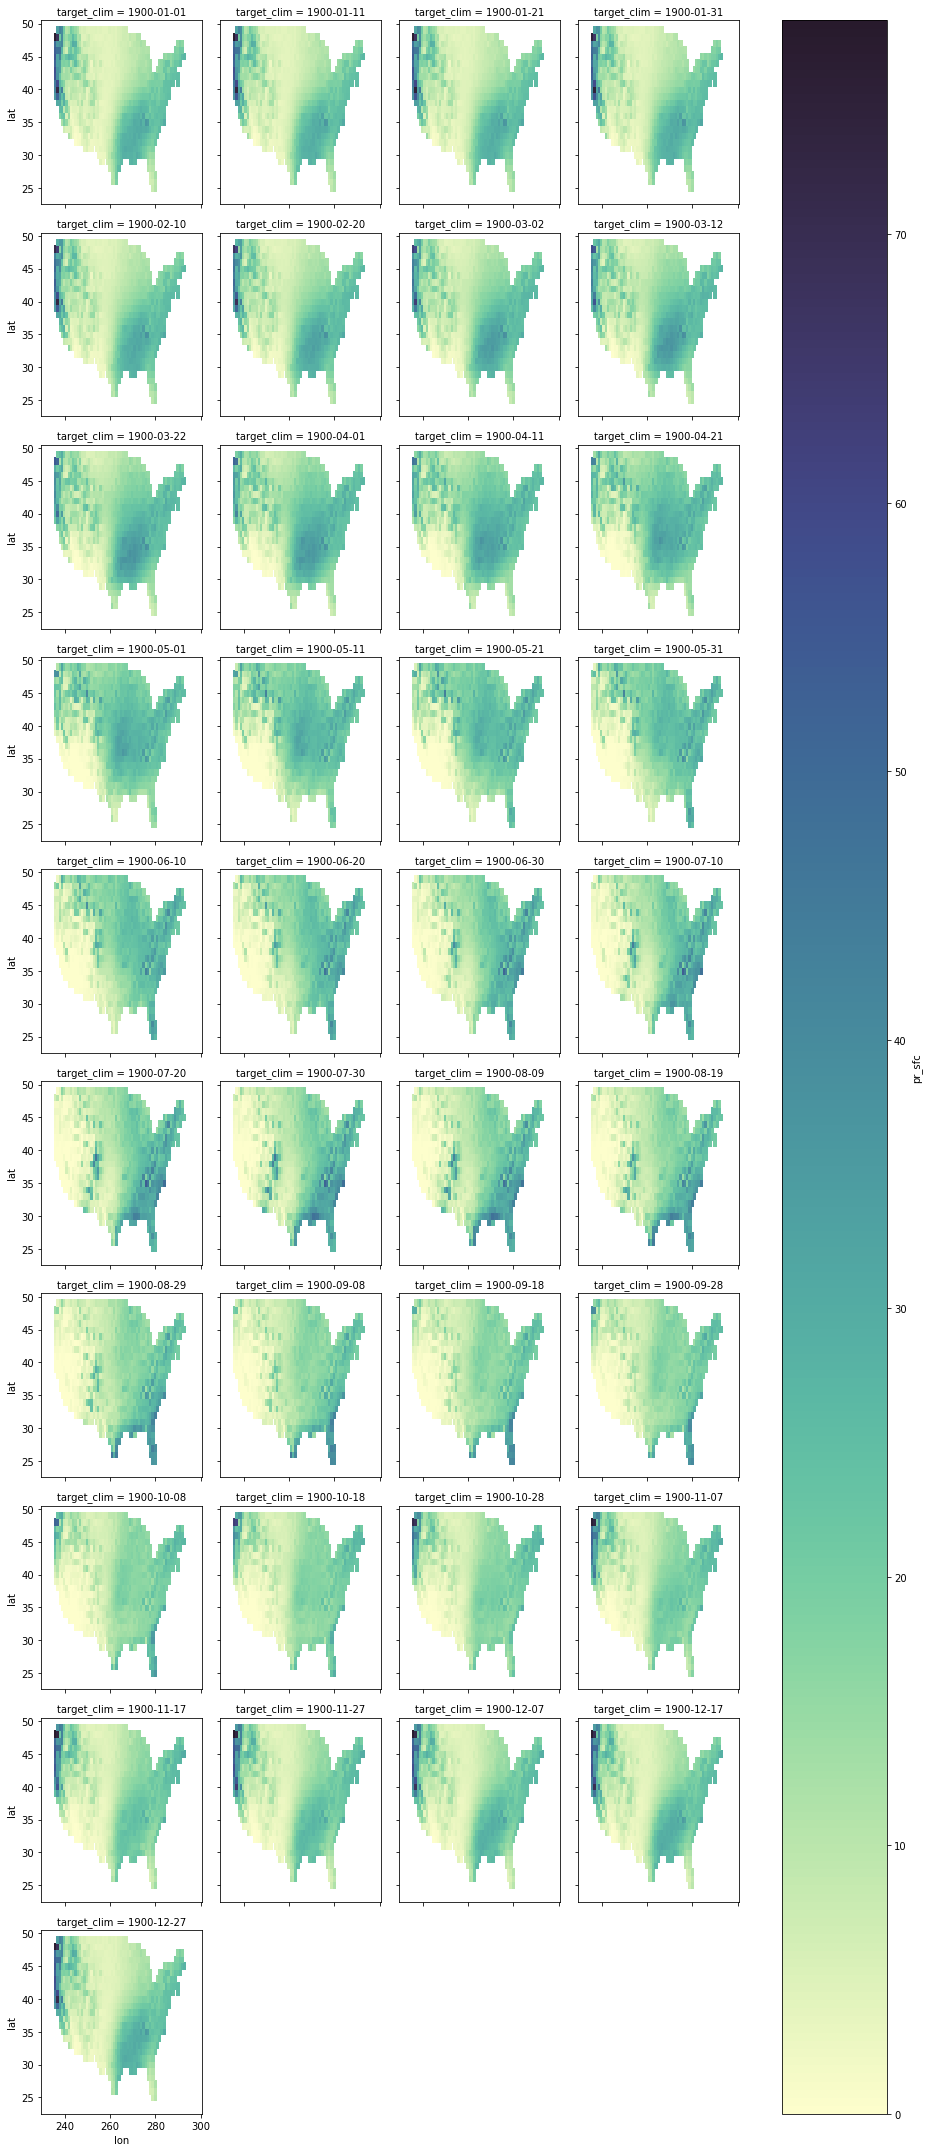

In [84]:
smooth_clim_cauchy_LongL.pr_sfc[::10,1].plot(col='target_clim',col_wrap=4, cmap=cmap)

In [87]:
smooth_clim_cauchy_LongL

<xarray.Dataset>
Dimensions:      (Lbeg: 2, lat: 28, lon: 71, target_clim: 365)
Coordinates:
  * Lbeg         (Lbeg) int64 4 14
  * lat          (lat) float64 23.0 24.0 25.0 26.0 27.0 ... 47.0 48.0 49.0 50.0
  * lon          (lon) float64 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * target_clim  (target_clim) datetime64[ns] 1900-01-01 ... 1900-12-31
Data variables:
    pr_sfc       (target_clim, Lbeg, lat, lon) float64 nan nan nan ... nan nan

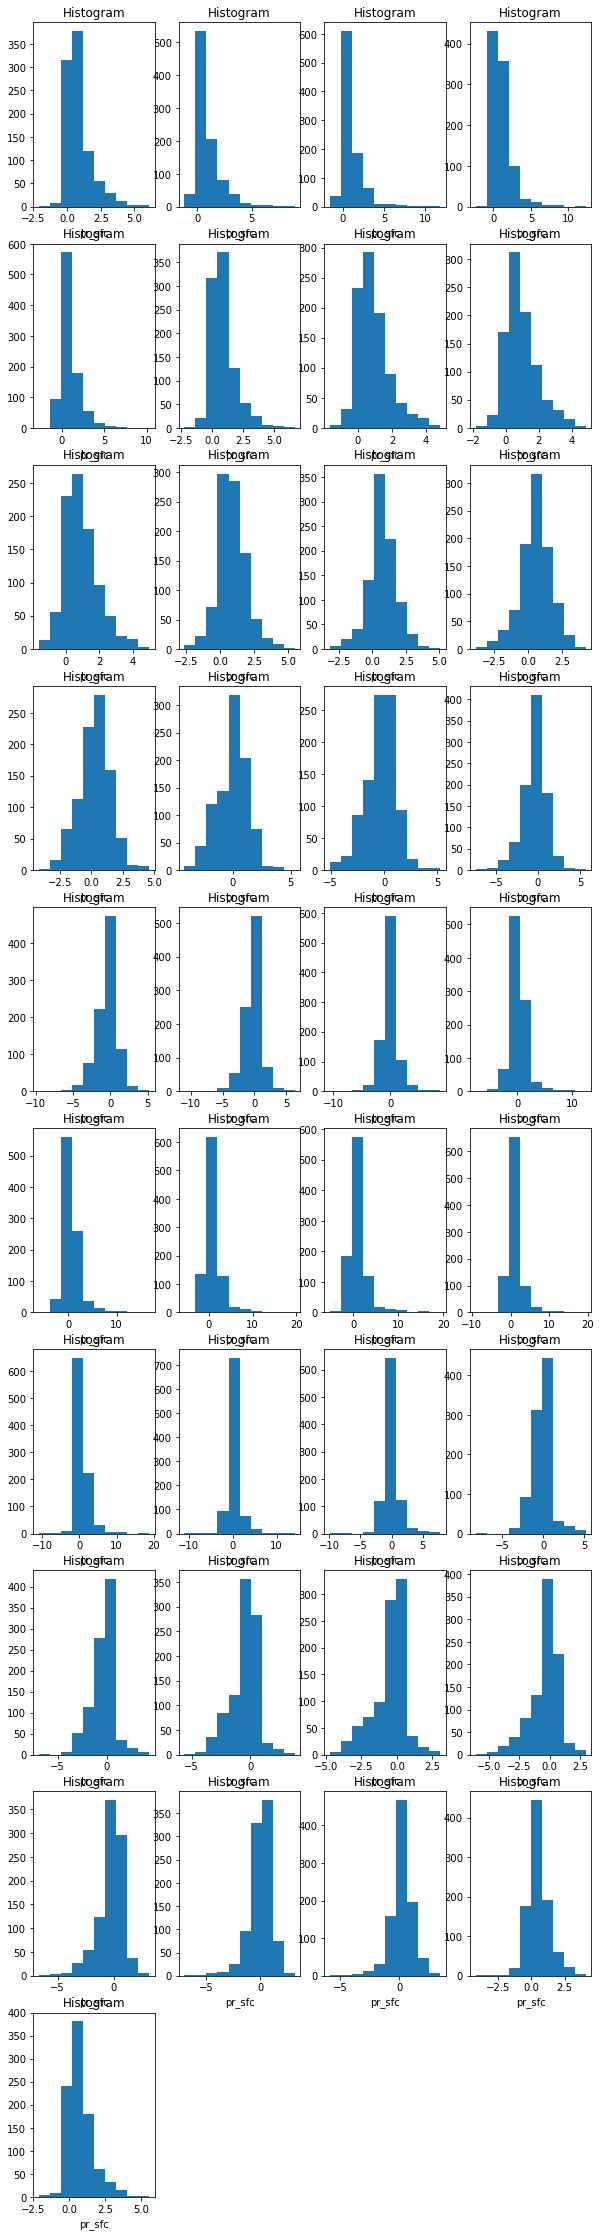

In [89]:
plt.figure(figsize=(10,40))
for iit, it in enumerate(np.arange(0, 366, 10)):
    ax = plt.subplot(10,4,iit+1)
    (smooth_clim_cauchy_LongL.pr_sfc[it,1]-smooth_clim_cauchy.pr_sfc[it,3]).plot.hist(ax = ax)

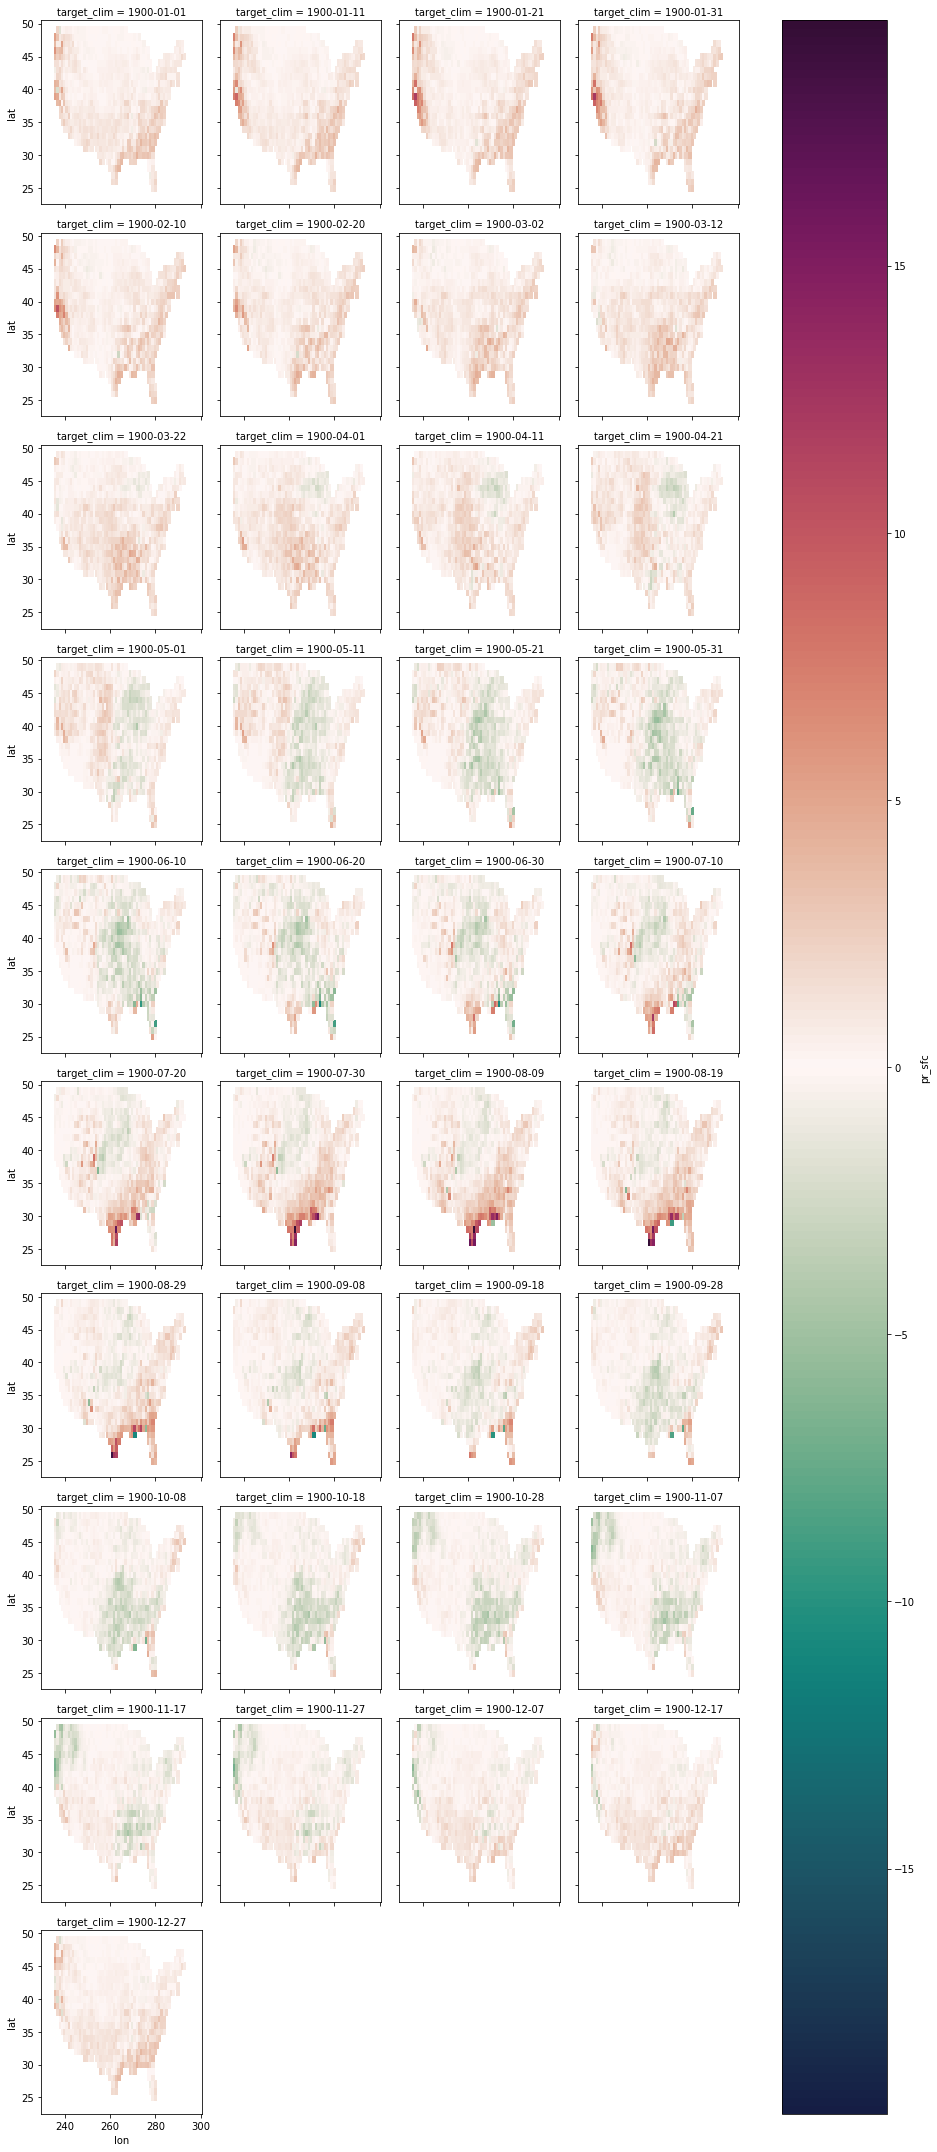

In [85]:
(smooth_clim_cauchy_LongL.pr_sfc[::10,1]-smooth_clim_cauchy.pr_sfc[::10,3]).plot(
    col='target_clim',col_wrap=4, cmap=cmocean.cm.curl)

In [ ]:
all_variables_T3

In [ ]:
smooth_clim_cauchy

In [ ]:
# looping through the target dates for climatologies
import warnings
warnings.filterwarnings("ignore")

check_85 = []
for iT in target_all:
    # extract values that correspond to the target dates
    temp = all_variables_T3.where((all_variables_T3.target_time.dt.month==iT.month.values[0])&
                              (all_variables_T3.target_time.dt.day==iT.day.values[0]), drop=True)
    smooth_data = smooth_clim_soft.where((smooth_clim_cauchy.target_clim.dt.month==iT.month.values[0])&
                              (smooth_clim_cauchy.target_clim.dt.day==iT.day.values[0]), drop=True)
    # bits to extract the S and t of each target_time
    y_ls = [y for (x,y) in temp.St.values]
    y_arr = np.array(y_ls)
    # loop through the 3 types of lead times
    # I have the -1 because of the way the timedelta is centered at 0 day and 12hours for day 1
#     for different_lead1, different_lead2 in zip(np.array([1,7,13])-1, np.array([5,11,17])-1 ):
    check_85b  = []
    for different_lead1, different_lead2 in zip(np.array([2,4,6,8])-1, np.array([10,12,14,16])-1 ):
#         print(y_arr[(y_arr>np.timedelta64(different_lead1,'D'))&(y_arr<np.timedelta64(different_lead2,'D'))])
        temp2 = temp.sel(target_time=
                         (y_arr>np.timedelta64(different_lead1,'D'))&(y_arr<np.timedelta64(different_lead2,'D')))
        smooth_data2 = smooth_data.sel(Lbeg=different_lead1+1)
        smooth_data2 = smooth_data2.rename({'target_clim':'target_time'})
        temp3 = temp2.stack(values = ['M','target_time'])
        diff  = temp3 - smooth_data2.isel(target_time=0) 
        diffbool = xr.where(diff.pr_sfc.where(ds_mask.the_geom>0)<0, 0,1)
        diffbool = diffbool.where(ds_mask.the_geom>0).sum('values')/diffbool.where(ds_mask.the_geom>0).count('values')
        diffbool = diffbool.expand_dims('Lbeg')
        diffbool = diffbool.expand_dims('target_time')
        check_85b.append(diffbool)
    check_85b = xr.combine_by_coords(check_85b)    
    check_85.append(check_85b)
    print(iT)
check_85 = xr.combine_by_coords(check_85)    


In [ ]:
#check_85_cauchy = check_85*1.


In [ ]:
for il in np.arange(0,4):
    check_85.groupby('target_time.month').mean().pr_sfc[:,il].where(ds_mask.the_geom>0).plot.contourf(
        col='month', col_wrap=6, levels=np.arange(0, 0.45, 0.05), cmap = 'RdBu_r')

In [ ]:
for ilat in np.arange(25,51,3):
    for ilon in np.arange(235,301,10):
        if np.sum(np.isnan(ds_mask.the_geom.where(ds_mask.the_geom>0).sel(lat=ilat, lon=ilon).values))==0:
            plt.figure(figsize=(10,3))
            ax = plt.subplot(121)
            check_85.pr_sfc[:,:,:,:].sel(lat=ilat, lon=ilon).plot.line(ax = ax, x='target_time')
            ax = plt.subplot(122)
#             smooth_clim_soft.pr_sfc[:,:,:,:].sel(lat=ilat, lon=ilon).plot.line('b',ax=ax,x='target_clim')
            ds_clim_test_3d_all.where(ds_mask.the_geom>0).pr_sfc[:,:,-1,:,:].sel(lat=ilat, lon=ilon).plot.line(ax=ax,x='target_clim')
            smooth_clim_cauchy.pr_sfc[:,:,:,:].sel(lat=ilat, lon=ilon).plot.line('k',ax=ax,x='target_clim')
